In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, Adadelta, Adagrad, RMSprop

In [2]:
fmnist = datasets.FashionMNIST(root='./data', train=True, download=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
tr_images.shape, tr_targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [3]:
val_fmnist = datasets.FashionMNIST(root='./data', train=False, download=True)
val_images = val_fmnist.data
val_targets = val_fmnist.targets
val_images.shape, val_targets.shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1, 28*28)
        self.x, self.y = x.to(device), y.to(device)
    
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
    
    def __len__(self):
        return len(self.x)
    

In [6]:
def get_model():
    SNet = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = Adam(SNet.parameters(), lr=1e-3)
    return SNet, loss, optimizer

In [7]:
def train_batch(X, y, SNet, optimizer, loss_fn):
    SNet.train()
    prediction = SNet(X)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [8]:
def accuracy(X, y, SNet):
    SNet.eval()
    with torch.no_grad():
        prediction = SNet(X)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [9]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [10]:
trn_dl, val_dl = get_data()
SNet, loss_fn, optimizer = get_model()

In [11]:
@torch.no_grad()
def val_loss(X, y, SNet):
    prediction = SNet(X)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [12]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        X, y = batch
        batch_loss = train_batch(X, y, SNet, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        X, y = batch
        is_correct = accuracy(X, y, SNet)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        X, y = batch
        val_is_correct = accuracy(X, y, SNet)
        validation_loss = val_loss(X, y, SNet)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


In [13]:
train_losses, train_accuracies, val_losses, val_accuracies

([0.47943845474720004,
  0.3584632736643155,
  0.3194368059833845,
  0.29590945073564845,
  0.2774641015807788,
  0.2616016207039356,
  0.24853820322950682,
  0.24022060792148114,
  0.22878538807332516,
  0.21977304385801155],
 [0.8695166666666667,
  0.8789166666666667,
  0.8866333333333334,
  0.8947333333333334,
  0.906,
  0.9135833333333333,
  0.9047333333333333,
  0.9158833333333334,
  0.9177,
  0.9246666666666666],
 [0.4034688472747803,
  0.37430840730667114,
  0.3661433756351471,
  0.3561277985572815,
  0.34060755372047424,
  0.3244016170501709,
  0.36265575885772705,
  0.3413052558898926,
  0.38372930884361267,
  0.3394506573677063],
 [0.8541,
  0.8628,
  0.8687,
  0.8751,
  0.8796,
  0.8878,
  0.8723,
  0.8831,
  0.8815,
  0.888])

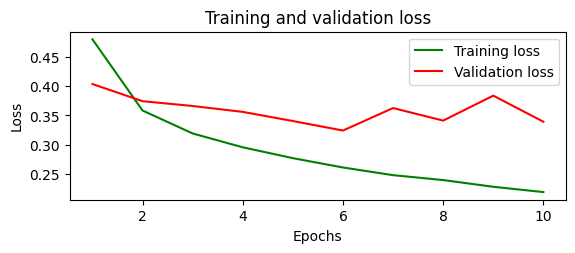

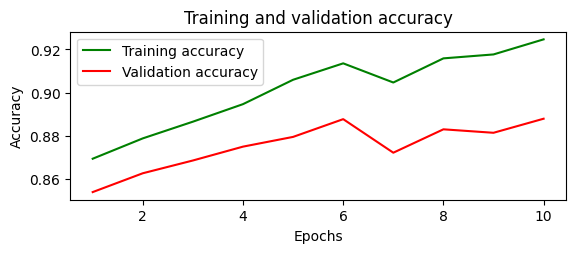

In [15]:
epochs = np.arange(10) + 1
plt.subplot(211)
plt.plot(epochs, train_losses, "g", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, "g", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()